In [1]:
import matplotlib.pyplot as plt  # 繪圖套件
import numpy as np  # 數值運算套件
from PIL import Image  # 圖片處理套件

# PyTorch 相關套件
import torch  # PyTorch 主套件
from torchvision import transforms  # 資料轉換工具
from torchvision.models import vgg16  # VGG-16 模型

# PyTorch Grad-CAM 套件
from pytorch_grad_cam import GradCAM  # 匯入 Grad-CAM 模組
from pytorch_grad_cam.utils.image import show_cam_on_image  # 顯示圖片與 CAM 的工具
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget  # 分類器輸出目標

# 載入模型

In [2]:
# 載入預訓練的 VGG 模型
model = vgg16(pretrained=True)
# 設定為評估模式
model.eval()

# 定義圖像預處理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/Users/origin/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/origin/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 讀取原圖與遮罩

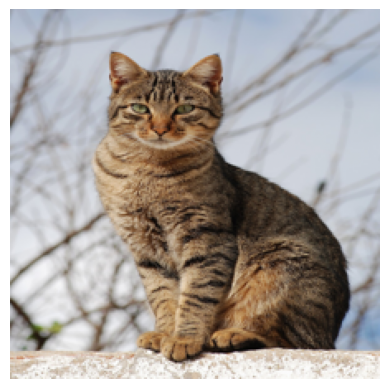

In [3]:
# 載入測試圖像與遮罩
img_path = './origin_image/cat2.jpg' 
mask_path = './mask_image/cat2.png'
img = Image.open(img_path)

# 顯示原始圖像
plt.imshow(np.array(img.resize((224, 224))) / 255.0)
plt.axis('off')
plt.show()

In [4]:
# 增加 Batch 維度
input_tensor = transform(img).unsqueeze(0)

# 預測
output = model(input_tensor)

# 索引找出預測標籤
idx = torch.argmax(output, dim=1).item()

imagenet_labels = []
with open('imagenet_classes.txt', 'r') as f:
    imagenet_labels = [line.strip() for line in f.readlines()]
    
print('預測結果：', torch.argmax(output, dim=1).item())
print('預測標籤：', imagenet_labels[idx])

預測結果： 285
預測標籤： Egyptian cat


In [5]:
# 顯示模型結構
print(model)

# 設置 Grad-CAM，選擇要觀察的卷積層
target_layers = [model.features[28]]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

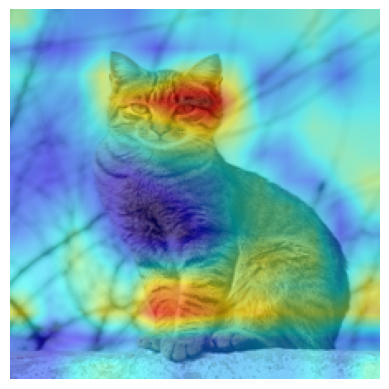

In [6]:
# 創建 Grad-CAM 物件
cam = GradCAM(model=model, target_layers=target_layers)

# 計算 Grad-CAM 熱力圖
targets = [ClassifierOutputTarget(idx)]  # (ImageNet的類別)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# 將熱力圖轉換成 2D 格式
grayscale_cam = grayscale_cam[0, :]  # 提取第 0 張圖像的 CAM 結果

# 將圖像轉換回 PIL 圖像以進行可視化
img = np.array(img.resize((224, 224))) / 255.0  # 圖像數據歸一化到 [0, 1]
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

# 顯示結果
plt.imshow(visualization)
plt.axis('off')
plt.show()

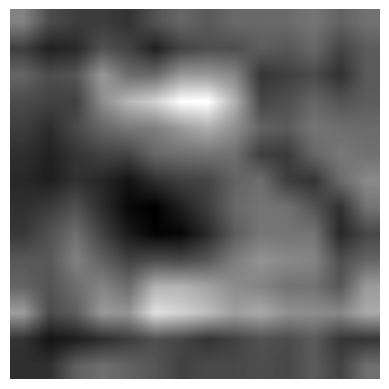

In [7]:
# 原始熱力圖灰度圖
plt.imshow(grayscale_cam, cmap='gray')
plt.axis('off')
plt.show()

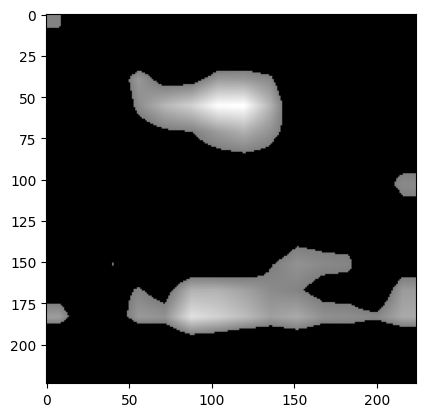

In [8]:
# 複製一份灰度圖
thresholded_grayscale_cam = grayscale_cam.copy()
# 將不足 < 閾值（關注度不高的區域）的像素設置為 0
thresholded_grayscale_cam[thresholded_grayscale_cam < 0.5] = 0
# 顯示閾值處理後的熱力圖
plt.imshow(thresholded_grayscale_cam, cmap='gray')
plt.show()

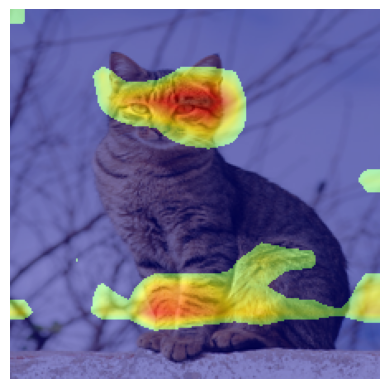

In [9]:
# 將熱力圖貼回原始圖像
visualization = show_cam_on_image(img, thresholded_grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')
plt.show()

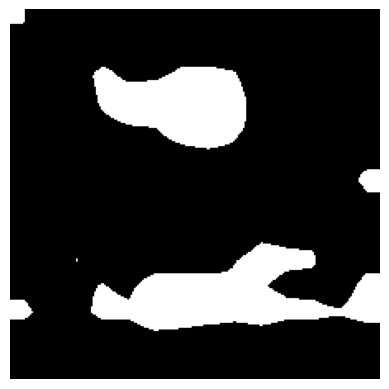

In [10]:
# 處理後的熱力圖二值化
binary_cam = (grayscale_cam > 0.5).astype(np.uint8)
plt.imshow(binary_cam, cmap='gray')
plt.axis('off')
plt.show()

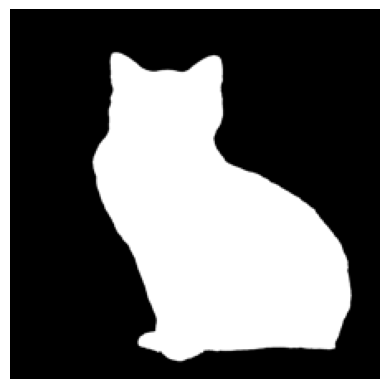

In [11]:
# 載入 SAM 真實 mask
real_binary_cam = Image.open(mask_path)
real_binary_cam = np.array(real_binary_cam.resize((224, 224))) / 255.0
plt.imshow(real_binary_cam, cmap='gray')
plt.axis('off')
plt.show()

## IoU 公式為：

$$IoU = \frac{交集的像素數量}{並集的像素數量}$$

In [12]:
# 計算 IoU
def calculate_iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    # 計算交集
    intersection = np.logical_and(mask1, mask2)
    
    # 計算聯集
    union = np.logical_or(mask1, mask2)
    
    # 計算 IoU
    iou = np.sum(intersection) / np.sum(union)
    
    return iou

In [13]:
# 假设 mask1 和 mask2 是您的两个二值化结果
iou_score = calculate_iou(real_binary_cam, binary_cam)

print(f"IoU 分數: {iou_score:.4f}")

IoU 分數: 0.2981


# 儲存結果

In [14]:
import os
import shutil

# 計算應該歸類到哪個區間
# 使用floor division將分數除以0.05後乘以0.05得到區間下限
folder_base = (iou_score // 0.05) * 0.05

# 計算區間的上限
folder_top = folder_base + 0.05
folder = f'{folder_base:.2f}-{folder_top:.2f}'
print(f'分數 {iou_score} 放在 {folder} 的資料夾')

分數 0.29811210302941604 放在 0.25-0.30 的資料夾


In [15]:
save_path = f'./result/{folder}'
os.makedirs(f'./result/{folder}', exist_ok=True)
shutil.copy(img_path, save_path)

'./result/0.25-0.30/cat2.jpg'